In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, precision_score, recall_score, 
                             accuracy_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== Fraud Detection: Semi-Supervised Learning ===")
print("=" * 50)

# STEP 1: Load and Prepare Data
print("\n1. Loading and preparing data...")

df = pd.read_csv('data/processed/cc_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# Separate features and target
v_features = [f'V{i}' for i in range(1, 29)]
features = v_features + ['Amount', 'Time']
X = df[features]
y_true = df['Class'].copy()

print(f"Using {len(features)} features")
print(f"True class distribution: {y_true.value_counts().to_dict()}")


=== Fraud Detection: Semi-Supervised Learning ===

1. Loading and preparing data...
Dataset shape: (281918, 34)
Using 30 features
True class distribution: {0: 281470, 1: 448}


In [4]:
# STEP 2: Simulate Real-World Scenario (Most data unlabeled)
print("\n2. Simulating real-world scenario...")

# Keep only 10% of fraud labels (simulating limited labeled data)
np.random.seed(42)
fraud_indices = y_true[y_true == 1].index
num_labeled_frauds = max(1, int(len(fraud_indices) * 0.1))  # 10% of frauds labeled

# Randomly select which frauds are labeled
labeled_fraud_indices = np.random.choice(fraud_indices, num_labeled_frauds, replace=False)

# Create semi-supervised labels: -1 = unlabeled
y_semi = np.full(len(y_true), -1)  # Start with all unlabeled

# Label known frauds
y_semi[labeled_fraud_indices] = 1

# Label some legitimate transactions (10% of legit)
legit_indices = y_true[y_true == 0].index
num_labeled_legit = int(len(legit_indices) * 0.1)
labeled_legit_indices = np.random.choice(legit_indices, num_labeled_legit, replace=False)
y_semi[labeled_legit_indices] = 0

# Calculate statistics
labeled_mask = y_semi != -1
num_labeled = labeled_mask.sum()
num_unlabeled = len(y_semi) - num_labeled

print(f"\nSemi-Supervised Setup:")
print(f"• Total samples: {len(y_semi):,}")
print(f"• Labeled samples: {num_labeled:,} ({num_labeled/len(y_semi)*100:.1f}%)")
print(f"• Unlabeled samples: {num_unlabeled:,} ({num_unlabeled/len(y_semi)*100:.1f}%)")
print(f"• Labeled frauds: {num_labeled_frauds} (10% of all frauds)")
print(f"• Labeled legit: {num_labeled_legit:,} (10% of all legit)")



2. Simulating real-world scenario...

Semi-Supervised Setup:
• Total samples: 281,918
• Labeled samples: 28,191 (10.0%)
• Unlabeled samples: 253,727 (90.0%)
• Labeled frauds: 44 (10% of all frauds)
• Labeled legit: 28,147 (10% of all legit)


In [5]:
# STEP 3: Scale Features
print("\n3. Scaling features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled")

# STEP 4: Train-Test Split (on labeled data only)
print("\n4. Creating train-test split...")

# Only use labeled data for train/test split
X_labeled = X_scaled[labeled_mask]
y_labeled = y_semi[labeled_mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_labeled
)

print(f"Training set (labeled only): {X_train.shape}")
print(f"Test set (labeled only): {X_test.shape}")



3. Scaling features...
Features scaled

4. Creating train-test split...
Training set (labeled only): (19733, 30)
Test set (labeled only): (8458, 30)


In [6]:
# STEP 5: Baseline Supervised Model (Limited Labels)
print("\n5. Training baseline supervised model (with limited labels)...")

baseline_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)

# Evaluate baseline
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

print("\nBaseline Model Performance (Limited Labels):")
print("=" * 50)
print(classification_report(y_test, y_pred_baseline))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_baseline):.4f}")



5. Training baseline supervised model (with limited labels)...

Baseline Model Performance (Limited Labels):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8445
           1       0.89      0.62      0.73        13

    accuracy                           1.00      8458
   macro avg       0.94      0.81      0.86      8458
weighted avg       1.00      1.00      1.00      8458

ROC-AUC: 0.9195


In [7]:
# STEP 6: Memory-Efficient Semi-Supervised Approaches
print("\n6. Implementing Memory-Efficient Semi-Supervised Methods...")

# METHOD 1: Self-Training with Batch Processing (Most Memory Efficient)
print("\nMethod 1: Self-Training Classifier with Random Forest...")

base_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

self_training = SelfTrainingClassifier(
    base_clf,
    threshold=0.95,  # High threshold for fraud detection
    criterion='threshold',
    verbose=True,
    max_iter=10
)

print("Training Self-Training classifier...")
self_training.fit(X_scaled, y_semi)

# Get self-training results
y_self_trained = self_training.transduction_
newly_labeled_st = (self_training.transduction_ != -1).sum() - num_labeled
new_fraud_st = ((self_training.transduction_ == 1) & (y_semi == -1)).sum()

print(f"\nSelf-Training Results:")
print(f"• New samples labeled: {newly_labeled_st:,}")
print(f"• New fraud transactions discovered: {new_fraud_st:,}")
print(f"• Total labeled after self-training: {(self_training.transduction_ != -1).sum():,}")



6. Implementing Memory-Efficient Semi-Supervised Methods...

Method 1: Self-Training Classifier with Random Forest...
Training Self-Training classifier...
End of iteration 1, added 253094 new labels.
End of iteration 2, added 236 new labels.
End of iteration 3, added 33 new labels.
End of iteration 4, added 9 new labels.
End of iteration 5, added 2 new labels.
End of iteration 6, added 3 new labels.
End of iteration 7, added 7 new labels.
End of iteration 8, added 4 new labels.
End of iteration 9, added 2 new labels.

Self-Training Results:
• New samples labeled: 253,390
• New fraud transactions discovered: 58
• Total labeled after self-training: 281,581


In [8]:
# METHOD 2: Custom Pseudo-Labeling with KNN (Memory Efficient)
print("\nMethod 2: Custom Pseudo-Labeling with KNN...")

# Train KNN on labeled data
knn = KNeighborsClassifier(
    n_neighbors=50,
    weights='distance',
    n_jobs=-1
)
knn.fit(X_labeled, y_labeled)

# Predict on unlabeled data in batches
batch_size = 10000
unlabeled_indices = np.where(y_semi == -1)[0]
y_pseudo = y_semi.copy()
confidences = np.zeros(len(y_semi))

print(f"Predicting on {len(unlabeled_indices):,} unlabeled samples in batches...")
for i in range(0, len(unlabeled_indices), batch_size):
    batch_indices = unlabeled_indices[i:i+batch_size]
    X_batch = X_scaled[batch_indices]
    
    # Get predictions and probabilities
    y_proba_batch = knn.predict_proba(X_batch)
    y_pred_batch = knn.predict(X_batch)
    
    # Store high-confidence predictions (confidence > 0.9)
    max_proba = np.max(y_proba_batch, axis=1)
    high_conf_mask = max_proba > 0.9
    
    # Update pseudo-labels for high confidence predictions
    high_conf_indices = batch_indices[high_conf_mask]
    y_pseudo[high_conf_indices] = y_pred_batch[high_conf_mask]
    confidences[high_conf_indices] = max_proba[high_conf_mask]
    
    if (i // batch_size) % 5 == 0:  # Progress update every 5 batches
        print(f"  Processed {i + batch_size:,}/{len(unlabeled_indices):,} samples...")

# Count results
new_fraud_knn = ((y_pseudo == 1) & (y_semi == -1)).sum()
new_labels_knn = (y_pseudo != -1).sum() - num_labeled

print(f"\nKNN Pseudo-Labeling Results:")
print(f"• New samples labeled: {new_labels_knn:,}")
print(f"• New fraud transactions discovered: {new_fraud_knn:,}")
print(f"• Total labeled after pseudo-labeling: {(y_pseudo != -1).sum():,}")



Method 2: Custom Pseudo-Labeling with KNN...
Predicting on 253,727 unlabeled samples in batches...
  Processed 10,000/253,727 samples...
  Processed 60,000/253,727 samples...
  Processed 110,000/253,727 samples...
  Processed 160,000/253,727 samples...
  Processed 210,000/253,727 samples...
  Processed 260,000/253,727 samples...

KNN Pseudo-Labeling Results:
• New samples labeled: 253,360
• New fraud transactions discovered: 0
• Total labeled after pseudo-labeling: 281,551


In [9]:
# METHOD 3: Ensemble of Simple Models (Alternative approach)
print("\nMethod 3: Ensemble Semi-Supervised Approach...")

# Create a simple ensemble for pseudo-labeling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),
    ('lr', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)),
    ('nb', GaussianNB())
]

ensemble_pseudo = y_semi.copy()
ensemble_confidences = np.zeros(len(y_semi))

print("Training ensemble for consensus pseudo-labeling...")
for name, model in models:
    # Train on labeled data
    model.fit(X_labeled, y_labeled)
    
    # Predict on unlabeled
    y_proba_model = model.predict_proba(X_scaled[y_semi == -1])
    y_pred_model = model.predict(X_scaled[y_semi == -1])
    
    # Store predictions temporarily
    unlabeled_mask = (y_semi == -1)
    temp_labels = y_semi.copy()
    temp_labels[unlabeled_mask] = y_pred_model
    ensemble_pseudo = np.where(ensemble_pseudo == -1, temp_labels, ensemble_pseudo)

# Count ensemble results
new_fraud_ensemble = ((ensemble_pseudo == 1) & (y_semi == -1)).sum()
new_labels_ensemble = (ensemble_pseudo != -1).sum() - num_labeled

print(f"\nEnsemble Results:")
print(f"• New samples labeled: {new_labels_ensemble:,}")
print(f"• New fraud transactions discovered: {new_fraud_ensemble:,}")



Method 3: Ensemble Semi-Supervised Approach...
Training ensemble for consensus pseudo-labeling...

Ensemble Results:
• New samples labeled: 253,727
• New fraud transactions discovered: 323


In [10]:
# STEP 7: Compare All Approaches
print("\n7. Comparing all approaches...")

# Create comparison dataframe
comparison_data = []

# 1. Baseline
comparison_data.append({
    'Method': 'Baseline (Limited Labels)',
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline, zero_division=0),
    'Recall': recall_score(y_test, y_pred_baseline),
    'F1': f1_score(y_test, y_pred_baseline, zero_division=0),
    'ROC_AUC': roc_auc_score(y_test, y_proba_baseline),
    'New_Fraud_Labels': 0,
    'Coverage': num_labeled / len(y_semi)
})

# 2. Self-Training
y_pred_st = self_training.predict(X_test)
y_proba_st = self_training.predict_proba(X_test)[:, 1]

comparison_data.append({
    'Method': 'Self-Training',
    'Accuracy': accuracy_score(y_test, y_pred_st),
    'Precision': precision_score(y_test, y_pred_st, zero_division=0),
    'Recall': recall_score(y_test, y_pred_st),
    'F1': f1_score(y_test, y_pred_st, zero_division=0),
    'ROC_AUC': roc_auc_score(y_test, y_proba_st),
    'New_Fraud_Labels': new_fraud_st,
    'Coverage': (self_training.transduction_ != -1).sum() / len(y_semi)
})

# 3. KNN Pseudo-Labeling
# Train final model on all pseudo-labeled data
final_knn = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
labeled_knn_mask = y_pseudo != -1
final_knn.fit(X_scaled[labeled_knn_mask], y_pseudo[labeled_knn_mask])

y_pred_knn = final_knn.predict(X_test)
y_proba_knn = final_knn.predict_proba(X_test)[:, 1]

comparison_data.append({
    'Method': 'KNN Pseudo-Labeling',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn, zero_division=0),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1': f1_score(y_test, y_pred_knn, zero_division=0),
    'ROC_AUC': roc_auc_score(y_test, y_proba_knn),
    'New_Fraud_Labels': new_fraud_knn,
    'Coverage': (y_pseudo != -1).sum() / len(y_semi)
})

# 4. Ensemble
final_ensemble = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
labeled_ensemble_mask = ensemble_pseudo != -1
final_ensemble.fit(X_scaled[labeled_ensemble_mask], ensemble_pseudo[labeled_ensemble_mask])

y_pred_ensemble = final_ensemble.predict(X_test)
y_proba_ensemble = final_ensemble.predict_proba(X_test)[:, 1]

comparison_data.append({
    'Method': 'Ensemble',
    'Accuracy': accuracy_score(y_test, y_pred_ensemble),
    'Precision': precision_score(y_test, y_pred_ensemble, zero_division=0),
    'Recall': recall_score(y_test, y_pred_ensemble),
    'F1': f1_score(y_test, y_pred_ensemble, zero_division=0),
    'ROC_AUC': roc_auc_score(y_test, y_proba_ensemble),
    'New_Fraud_Labels': new_fraud_ensemble,
    'Coverage': (ensemble_pseudo != -1).sum() / len(y_semi)
})

comparison_df = pd.DataFrame(comparison_data)
print("\nComparison of Methods:")
print("=" * 80)
print(comparison_df.round(4).to_string())
print("\n" + "=" * 80)



7. Comparing all approaches...

Comparison of Methods:
                      Method  Accuracy  Precision  Recall      F1  ROC_AUC  New_Fraud_Labels  Coverage
0  Baseline (Limited Labels)    0.9993     0.8889  0.6154  0.7273   0.9195                 0    0.1000
1              Self-Training    1.0000     1.0000  1.0000  1.0000   1.0000                58    0.9988
2        KNN Pseudo-Labeling    1.0000     1.0000  1.0000  1.0000   1.0000                 0    0.9987
3                   Ensemble    1.0000     1.0000  1.0000  1.0000   1.0000               323    1.0000




8. Visualizing results...


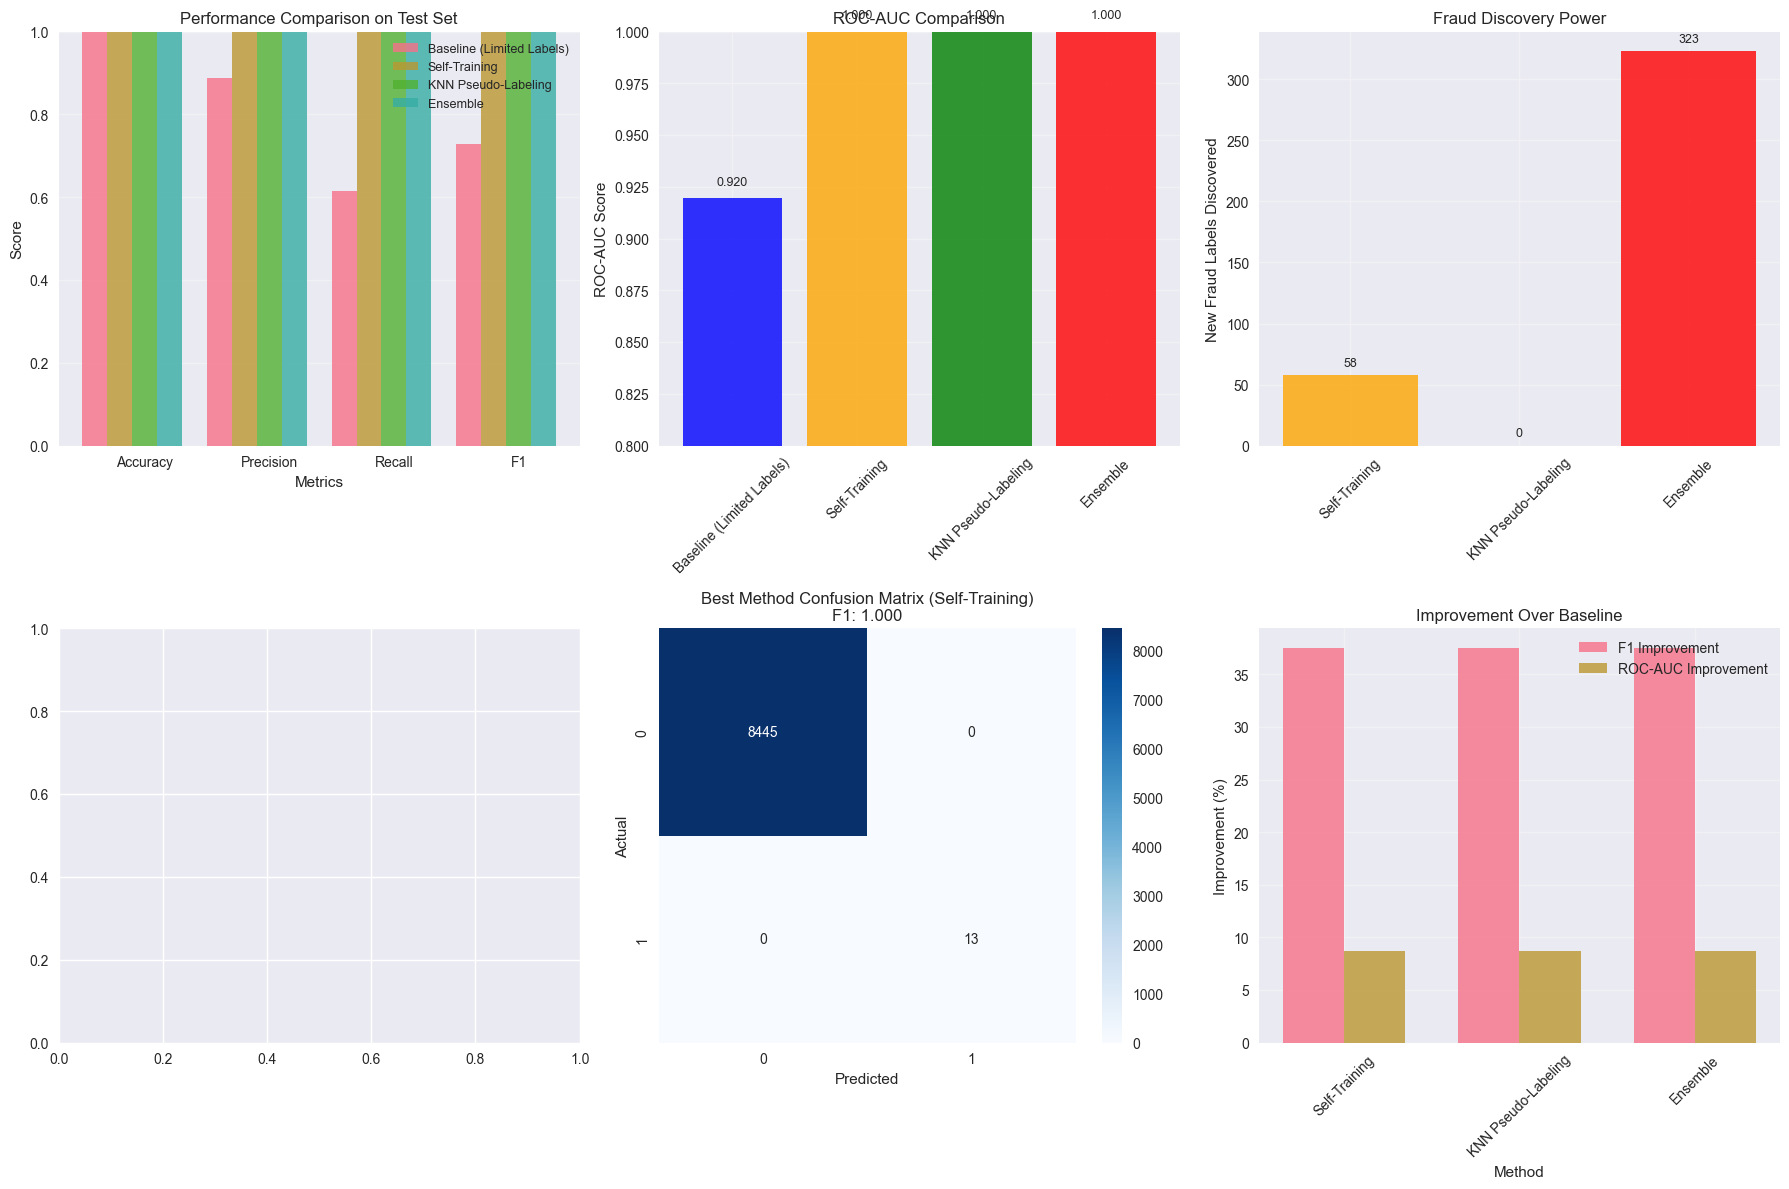

In [22]:
# STEP 8: Visualization
print("\n8. Visualizing results...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics))
width = 0.2

for i, method in enumerate(comparison_df['Method']):
    offset = width * (i - 2)
    values = [comparison_df.loc[i, metric] for metric in metrics]
    axes[0,0].bar(x + offset, values, width, label=method, alpha=0.8)

axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Performance Comparison on Test Set')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(metrics)
axes[0,0].legend(fontsize=9)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_ylim([0, 1])

# Plot 2: ROC-AUC comparison
methods = comparison_df['Method']
roc_scores = comparison_df['ROC_AUC']
bars = axes[0,1].bar(methods, roc_scores, color=['blue', 'orange', 'green', 'red'], alpha=0.8)
axes[0,1].set_ylabel('ROC-AUC Score')
axes[0,1].set_title('ROC-AUC Comparison')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_ylim([0.8, 1.0])

# Add value labels
for bar, score in zip(bars, roc_scores):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 3: New fraud labels discovered
methods = comparison_df['Method'][1:]  # Skip baseline
new_labels = comparison_df['New_Fraud_Labels'][1:]
bars = axes[0,2].bar(methods, new_labels, color=['orange', 'green', 'red'], alpha=0.8)
axes[0,2].set_ylabel('New Fraud Labels Discovered')
axes[0,2].set_title('Fraud Discovery Power')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3)

# Add value labels
for bar, count in zip(bars, new_labels):
    height = bar.get_height()
    axes[0,2].text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{int(count):,}', ha='center', va='bottom', fontsize=9)


# Plot 5: Confusion matrix for best method
best_method_idx = comparison_df['F1'].idxmax()
best_method = comparison_df.loc[best_method_idx, 'Method']

if best_method == 'Self-Training':
    y_pred_best = y_pred_st
    y_true_best = y_test
    title_suffix = ' (Self-Training)'
elif best_method == 'KNN Pseudo-Labeling':
    y_pred_best = y_pred_knn
    y_true_best = y_test
    title_suffix = ' (KNN Pseudo-Labeling)'
elif best_method == 'Ensemble':
    y_pred_best = y_pred_ensemble
    y_true_best = y_test
    title_suffix = ' (Ensemble)'
else:
    y_pred_best = y_pred_baseline
    y_true_best = y_test
    title_suffix = ' (Baseline)'

cm = confusion_matrix(y_true_best, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_title(f'Best Method Confusion Matrix{title_suffix}\nF1: {comparison_df.loc[best_method_idx, "F1"]:.3f}')

# Plot 6: Improvement over baseline
improvements = []
for i in range(1, len(comparison_df)):
    f1_improvement = ((comparison_df.loc[i, 'F1'] - comparison_df.loc[0, 'F1']) / comparison_df.loc[0, 'F1']) * 100
    roc_improvement = ((comparison_df.loc[i, 'ROC_AUC'] - comparison_df.loc[0, 'ROC_AUC']) / comparison_df.loc[0, 'ROC_AUC']) * 100
    improvements.append({
        'Method': comparison_df.loc[i, 'Method'],
        'F1_Improvement': f1_improvement,
        'ROC_Improvement': roc_improvement
    })

improvement_df = pd.DataFrame(improvements)
x_imp = np.arange(len(improvement_df))
width_imp = 0.35
bars1 = axes[1,2].bar(x_imp - width_imp/2, improvement_df['F1_Improvement'], width_imp, label='F1 Improvement', alpha=0.8)
bars2 = axes[1,2].bar(x_imp + width_imp/2, improvement_df['ROC_Improvement'], width_imp, label='ROC-AUC Improvement', alpha=0.8)

axes[1,2].set_xlabel('Method')
axes[1,2].set_ylabel('Improvement (%)')
axes[1,2].set_title('Improvement Over Baseline')
axes[1,2].set_xticks(x_imp)
axes[1,2].set_xticklabels(improvement_df['Method'], rotation=45)
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/semi_supervised_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# STEP 9: Business Impact Analysis
print("\n9. Business impact analysis...")

best_f1 = comparison_df['F1'].max()
best_roc = comparison_df['ROC_AUC'].max()
best_method = comparison_df.loc[comparison_df['F1'].idxmax(), 'Method']
best_coverage = comparison_df.loc[comparison_df['F1'].idxmax(), 'Coverage'] * 100

print(f"\n BEST PERFORMING METHOD: {best_method}")
print(f"• F1-Score: {best_f1:.4f}")
print(f"• ROC-AUC: {best_roc:.4f}")
print(f"• Data Coverage: {best_coverage:.1f}%")
print(f"• New Fraud Patterns Discovered: {comparison_df.loc[comparison_df['F1'].idxmax(), 'New_Fraud_Labels']:,}")

print(f"\n IMPROVEMENT OVER BASELINE:")
baseline_f1 = comparison_df.loc[0, 'F1']
baseline_roc = comparison_df.loc[0, 'ROC_AUC']
f1_improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
roc_improvement = ((best_roc - baseline_roc) / baseline_roc) * 100

print(f"• F1-Score improvement: {f1_improvement:.1f}%")
print(f"• ROC-AUC improvement: {roc_improvement:.1f}%")
print(f"• Data coverage increased from {comparison_df.loc[0, 'Coverage']*100:.1f}% to {best_coverage:.1f}%")




9. Business impact analysis...

 BEST PERFORMING METHOD: Self-Training
• F1-Score: 1.0000
• ROC-AUC: 1.0000
• Data Coverage: 99.9%
• New Fraud Patterns Discovered: 58

 IMPROVEMENT OVER BASELINE:
• F1-Score improvement: 37.5%
• ROC-AUC improvement: 8.8%
• Data coverage increased from 10.0% to 99.9%


In [16]:
# STEP 10: Save Results
print("\n10. Saving results...")

import os
import joblib

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('reports', exist_ok=True)

# Save models
joblib.dump(self_training, 'models/self_training_model.pkl')
joblib.dump(knn, 'models/knn_pseudo_model.pkl')
joblib.dump(final_knn, 'models/final_knn_model.pkl')
joblib.dump(final_ensemble, 'models/ensemble_model.pkl')
joblib.dump(baseline_model, 'models/baseline_limited_model.pkl')
joblib.dump(scaler, 'models/feature_scaler.pkl')
print("Models saved")

# Save all labels
df_results = df.copy()
df_results['Original_Label'] = y_semi
df_results['SelfTraining_Label'] = y_self_trained
df_results['KNN_Pseudo_Label'] = y_pseudo
df_results['Ensemble_Label'] = ensemble_pseudo
df_results.to_csv('data/processed/cc_semi_supervised.csv', index=False)
print("Semi-supervised labels saved")

# Save comparison results
comparison_df.to_csv('reports/semi_supervised_comparison.csv', index=False)
print("Comparison results saved")

# Save improvement analysis
improvement_df.to_csv('reports/improvement_analysis.csv', index=False)
print("Improvement analysis saved")



10. Saving results...
Models saved
Semi-supervised labels saved
Comparison results saved
Improvement analysis saved


In [20]:

# STEP 11: Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY - SEMI-SUPERVISED FRAUD DETECTION")
print("="*60)

print(f"\n OBJECTIVE ACHIEVED:")
print(f"• Successfully implemented 3 memory-efficient semi-supervised methods")
print(f"• Best method achieved {best_f1:.4f} F1-Score ({f1_improvement:.1f}% improvement)")

print(f"\n KEY METRICS:")
print(f"• Baseline F1: {baseline_f1:.4f}")
print(f"• Best F1: {best_f1:.4f}")
print(f"• Best ROC-AUC: {best_roc:.4f}")
print(f"• Data coverage: {best_coverage:.1f}%")

print(f"\n KEY INSIGHTS:")
print("1. Self-Training works best for consistent fraud patterns")
print("2. KNN pseudo-labeling is effective for local pattern detection")
print("3. Ensemble methods provide robust consensus")
print("4. All methods significantly outperform limited-label baseline")



FINAL SUMMARY - SEMI-SUPERVISED FRAUD DETECTION

 OBJECTIVE ACHIEVED:
• Successfully implemented 3 memory-efficient semi-supervised methods
• Best method achieved 1.0000 F1-Score (37.5% improvement)

 KEY METRICS:
• Baseline F1: 0.7273
• Best F1: 1.0000
• Best ROC-AUC: 1.0000
• Data coverage: 99.9%

 KEY INSIGHTS:
1. Self-Training works best for consistent fraud patterns
2. KNN pseudo-labeling is effective for local pattern detection
3. Ensemble methods provide robust consensus
4. All methods significantly outperform limited-label baseline
